# Imports

In [1]:
import os
import sys
from functools import reduce
from pathlib import Path

sys.path.extend(['/Users/fabianloewe/Projects/master-thesis/tools/aletheia'])

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import aletheialib.attacks as attacks
import aletheialib.options.tools as tools

# Prepare data

In [2]:
EMBEDDING_METHODS = [
    'MobiStego', 'Passlok', 'Pictograph', 'PixelKnot', 'PocketStego', 'SteganographyM'
]

BASE_PATH = Path('../datasets/StegoAppDB_stegos_20240309-030352')

df = pd.read_csv(BASE_PATH / 'StegoAppDB_stegos_20240309-030352_stego_directory.csv')

dfs = {m: df[df['embedding_method'] == m] for m in EMBEDDING_METHODS}
dfs_image_pairs = {
    m: list((BASE_PATH / 'covers' / ci, BASE_PATH / 'stegos' / si) for ci, si in
            zip(dfs[m]['cover_image_filename'], dfs[m]['image_filename']))
    for m in EMBEDDING_METHODS
}

# Compute file size diffs

In [3]:
all_size_diffs = {
    m: attacks.size_diff(image_pairs)
    for m, image_pairs in dfs_image_pairs.items()
}

<Axes: xlabel='Dateigrößenunterschied in Prozent', ylabel='Stego-App'>

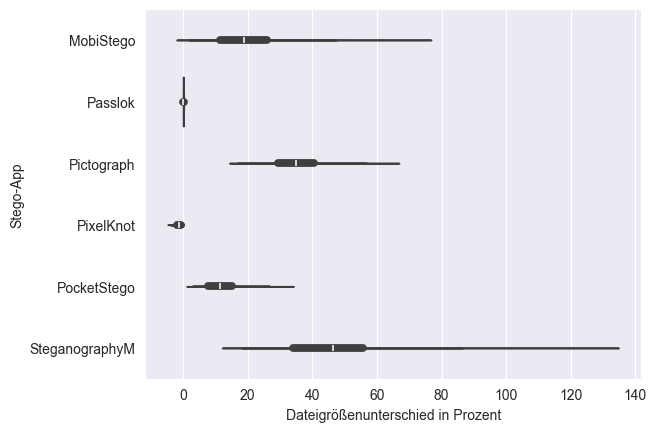

In [4]:
size_diffs_df = pd.DataFrame(
    ((method, *size_diff) for method, size_diffs in all_size_diffs.items() for size_diff in size_diffs),
    columns=['Stego-App', 'Cover', 'Stego', 'Dateigrößenunterschied in Bytes', 'Dateigrößenunterschied in Prozent'])
sns.violinplot(data=size_diffs_df, x='Dateigrößenunterschied in Prozent', y='Stego-App')

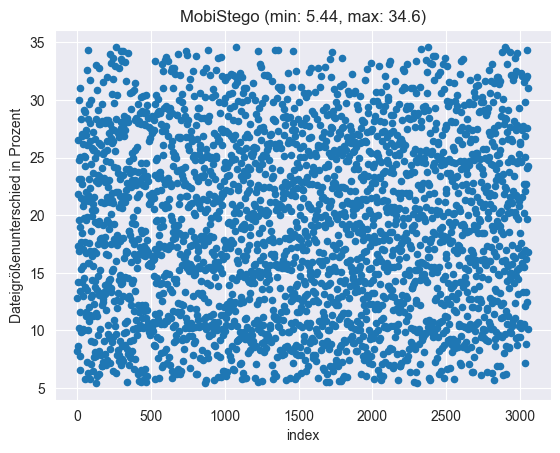

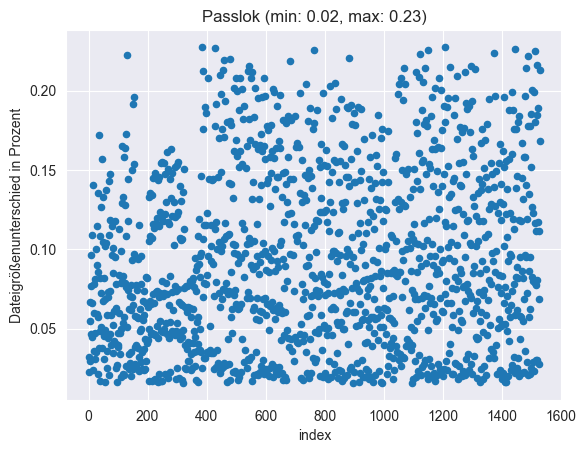

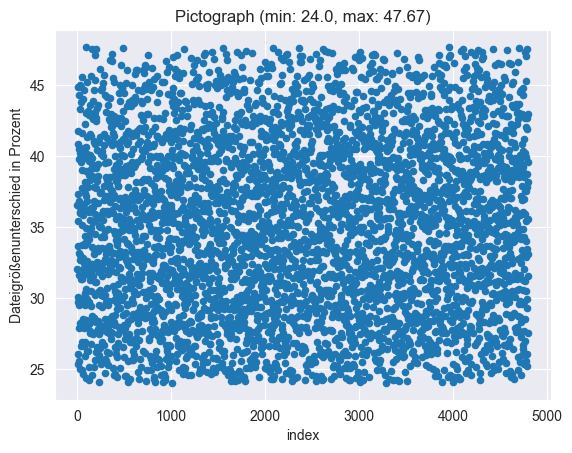

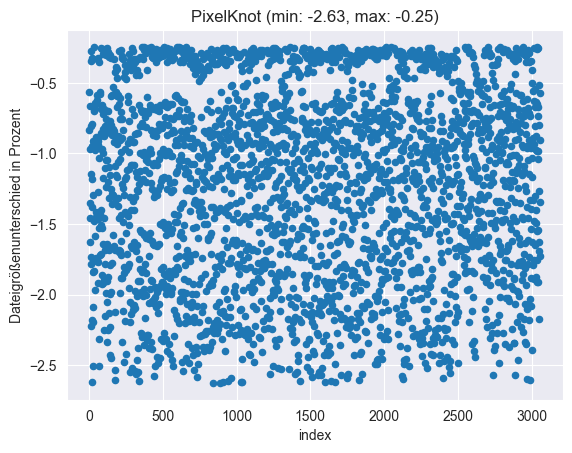

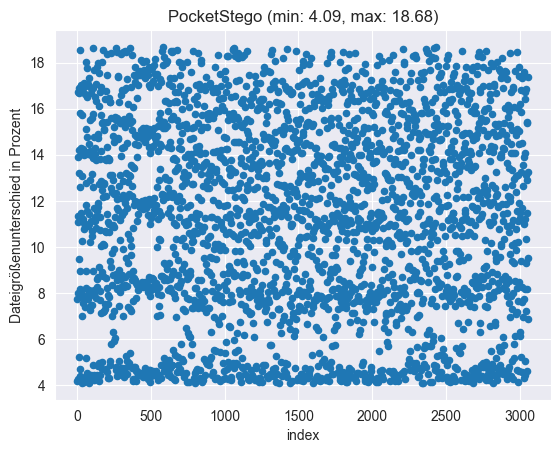

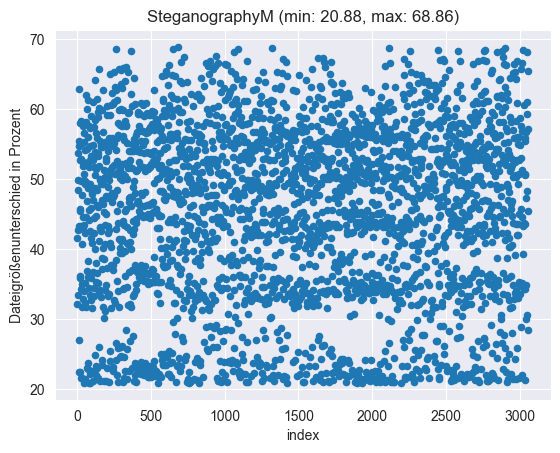

In [6]:
THRESHOLD_LOW = 0.05
THRESHOLD_HIGH = 0.95

FILE_SIZE_DIFF_PERCENTAGE = 'Dateigrößenunterschied in Prozent'

size_diffs_no_outliers = {}
for method, size_diffs in all_size_diffs.items():
    size_diffs_df = pd.DataFrame(size_diffs,
                                 columns=['Cover', 'Stego', 'Dateigrößenunterschied in Bytes', FILE_SIZE_DIFF_PERCENTAGE])
    size_diffs_df.sort_values(by=FILE_SIZE_DIFF_PERCENTAGE, inplace=True)

    mean_above_0 = size_diffs_df[FILE_SIZE_DIFF_PERCENTAGE].mean() > 0
    q_low = size_diffs_df[FILE_SIZE_DIFF_PERCENTAGE].quantile(THRESHOLD_LOW) if mean_above_0 else size_diffs_df[
        FILE_SIZE_DIFF_PERCENTAGE].quantile(THRESHOLD_HIGH)
    q_high = size_diffs_df[FILE_SIZE_DIFF_PERCENTAGE].quantile(THRESHOLD_HIGH) if mean_above_0 else size_diffs_df[
        FILE_SIZE_DIFF_PERCENTAGE].quantile(THRESHOLD_LOW)
    size_diffs_df = (size_diffs_df[(size_diffs_df[FILE_SIZE_DIFF_PERCENTAGE] > q_low) & (
            size_diffs_df[FILE_SIZE_DIFF_PERCENTAGE] < q_high)]
                     if mean_above_0
                     else size_diffs_df[(size_diffs_df[FILE_SIZE_DIFF_PERCENTAGE] < q_low) & (
            size_diffs_df[FILE_SIZE_DIFF_PERCENTAGE] > q_high)])
    size_diffs_no_outliers[method] = size_diffs_df
    size_diffs_df.reset_index()
    size_diffs_df['index'] = size_diffs_df.index
    size_diffs_df.plot.scatter(x='index', y=FILE_SIZE_DIFF_PERCENTAGE,
                               title=f'{method} (min: {round(size_diffs_df[FILE_SIZE_DIFF_PERCENTAGE].min(), 2)}, max: {round(size_diffs_df[FILE_SIZE_DIFF_PERCENTAGE].max(), 2)})')

<Figure size 1500x800 with 0 Axes>

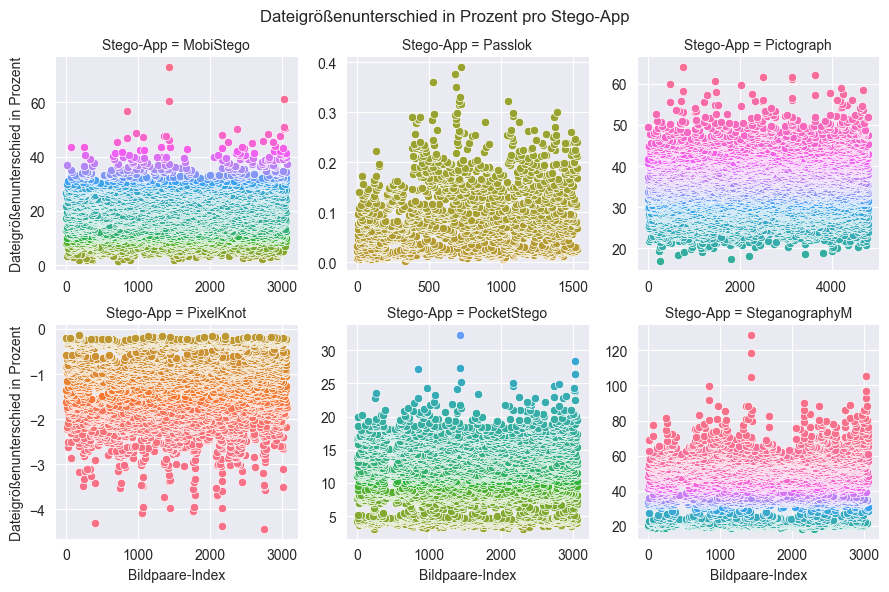

In [8]:
def create_facet_plot():
    size_diffs_df = pd.DataFrame(
        [(method, num, *size_diff) for method, size_diffs in all_size_diffs.items() for num, size_diff in enumerate(size_diffs)],
        columns=['Stego-App', 'Bildpaare-Index', 'Cover', 'Stego', 'Dateigrößenunterschied in Bytes', 'Dateigrößenunterschied in Prozent'])

    plt.figure(figsize=(15, 8))
    g = sns.FacetGrid(size_diffs_df, col='Stego-App', col_wrap=3, sharex=False, sharey=False, hue='Dateigrößenunterschied in Prozent')
    g.map(sns.scatterplot, 'Bildpaare-Index', 'Dateigrößenunterschied in Prozent')
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle('Dateigrößenunterschied in Prozent pro Stego-App')
    g.savefig('../assets/images/file-size-diff-percentage-per-method.png')
    plt.show()


create_facet_plot()

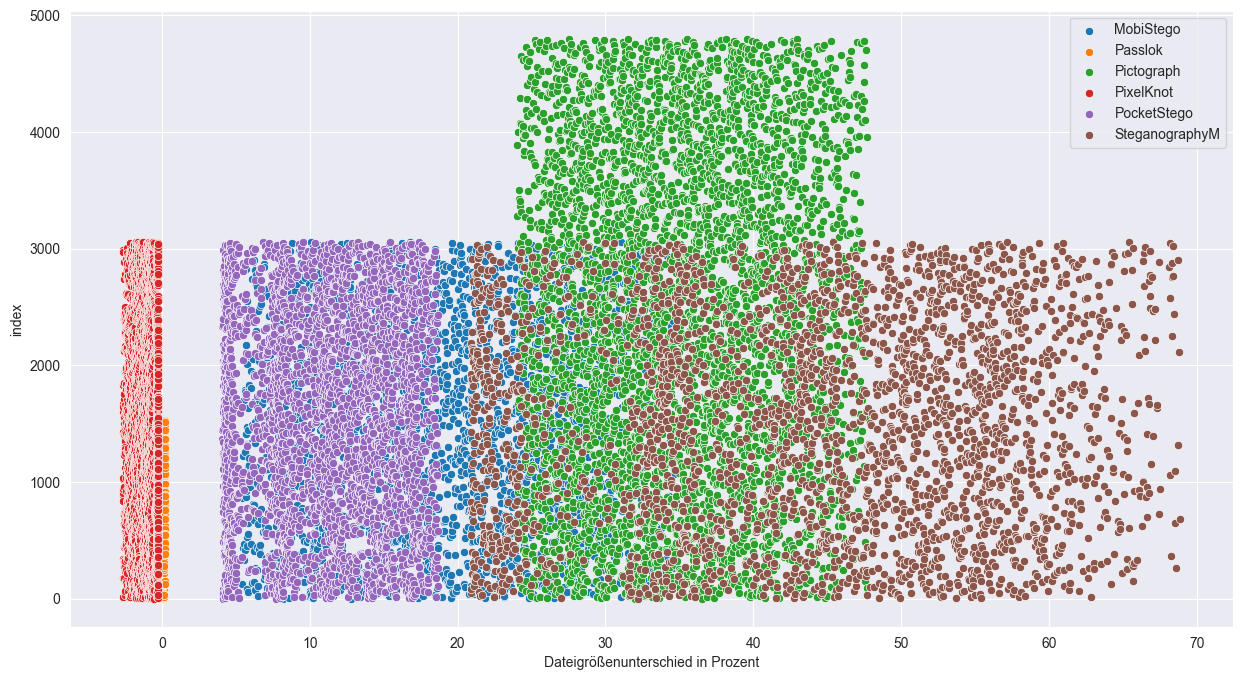

In [7]:
plt.figure(figsize=(15, 8))
for method, size_diffs in size_diffs_no_outliers.items():
    sns.scatterplot(data=size_diffs, x='Dateigrößenunterschied in Prozent', y='index', legend='brief', label=method)
plt.show()